In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit import QuantumRegister, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

from HDT_circuit_qiskit import HEA_circuit_estimator

import matplotlib.pyplot as plt

import time

sns.set()

In [2]:
def create_circuit(n_step, n_depth, n_bath):
    n_wires = 2 + n_bath
    n_param = 2 * n_depth * n_step

    # circuit parameter storages
    param_data0 = ParameterVector('data_0', length=n_param)
    param_data1 = ParameterVector('data_1', length=n_param)
    param_bath = [ParameterVector(
        'bath_' + str(b), length=n_param) for b in range(n_bath)]

    q = QuantumRegister(n_wires, 'q')
    circuit = QuantumCircuit(q)

    for t in range(n_step):
        for d in range(n_depth):
            param_id = 2 * d + 2 * n_depth * t
            circuit.ry(param_data0[param_id], 0)
            circuit.rz(param_data0[param_id + 1], 0)
            circuit.ry(param_data1[param_id], 1)
            circuit.rz(param_data1[param_id + 1], 1)

            for b in range(n_bath):
                circuit.ry(param_bath[b][param_id], 2 + b)
                circuit.rz(param_bath[b][param_id + 1], 2 + b)

            circuit.cx(0, 1)

            for b in range(n_bath - 1):
                circuit.cx(2 + b, 2 + b + 1)

            circuit.cx(1, 2)

        if t < n_step - 1:
            for b in range(n_bath):
                circuit.reset(2 + b)

    return circuit

In [3]:
def FP1evo(dA, dB, ts):
    r = (dA**2 - 1)*dB/(dA**2 * dB**2 - 1)
    c = dA*(dB + 1) + (dA - 1)*(dA * dB - 1)*r**ts
    return c/(dA**2 * dB + 1)

## $2+2$ Qubits, HEA circuit

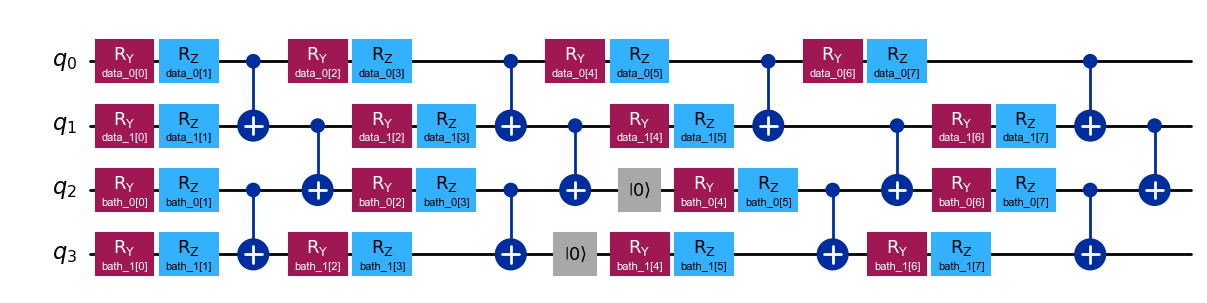

In [4]:
# plot a simple circuit
circuit = HEA_circuit_estimator(2, 2, 2, 2)
circuit.draw('mpl')

In [5]:
# setup backend and estimator
# backend = FakeSherbrooke()
# backend = AerProvider().get_backend()
backend = AerSimulator()
estimator = EstimatorV2(mode=backend)

In [ ]:
n_qubit = 4
pauli_op = ["I", "X", "Y", "Z"]
observables = [[Pauli('II' + q + p)] for p in pauli_op for q in pauli_op][1:]

In [7]:
# simple test run
n_batch = 10
n_step = 1
n_depth = 4
n_data = 2
n_bath = 2

n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)
param_random = np.random.uniform(0, 4. * np.pi, (n_batch, n_total_param))

circuit = HEA_circuit_estimator(n_step, n_depth, n_data, n_bath)

pub = (circuit, observables, param_random)
job = estimator.run([pub])
r_vals = job.result()[0].data.evs
purity = (1. + (r_vals ** 2.).sum(0)) / 4.

print("Purity: ", purity.mean())

Purity:  0.4977834165096283


In [8]:
# noise-free simulation
n_batch = 10
n_depth = 5
n_data = 2
n_bath = 2

purities = []
for n_step in range(1, 9):
    t0 = time.time()
    np.random.seed(12)
    n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, (n_batch, n_total_param))
    
    circuit = HEA_circuit_estimator(n_step, n_depth, n_data, n_bath)
    
    pub = (circuit, observables, param_random)
    job = estimator.run([pub])
    r_vals = job.result()[0].data.evs
    purity = (1. + (r_vals ** 2.).sum(0)) / 4.

    purities.append(purity)
    print(f'step {n_step}, time={time.time() - t0:.3f} sec')

purities = np.array(purities)

step 1, time=1.465 sec
step 2, time=5.028 sec
step 3, time=6.999 sec
step 4, time=9.250 sec
step 5, time=12.848 sec
step 6, time=14.084 sec
step 7, time=15.776 sec
step 8, time=17.774 sec


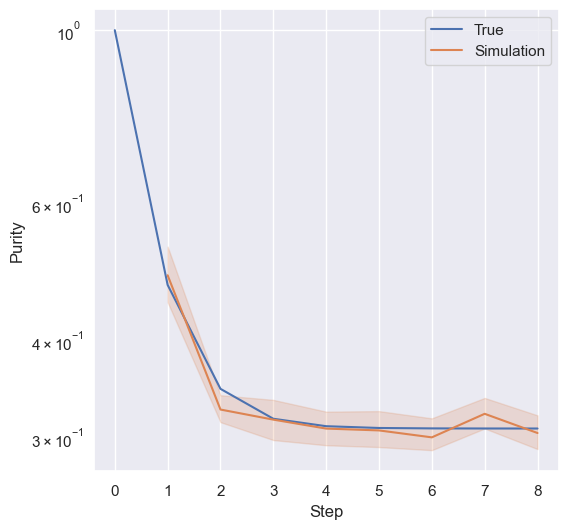

In [9]:
# plot simulated vs true purities
purities_df = pd.DataFrame(purities.T, columns=range(1, 9)).melt()
purities_df.columns=['Step', 'Purity']

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.lineplot(FP1evo(4, 4, np.arange(9)), errorbar=None, ax=ax)
sns.lineplot(data=purities_df, x='Step', y='Purity', legend='brief', ax=ax)
ax.set(yscale='log')
ax.legend(['True', 'Simulation'])

## $2+2$ Qubits, Noise Simulation

In [10]:
backend = FakeSherbrooke()
estimator = EstimatorV2(mode=backend)

In [11]:
n_batch = 10
n_depth = 5
n_data = 5
n_bath = 2

purities = []
for n_step in range(1, 9):
    t0 = time.time()
    np.random.seed(12)
    n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, (n_batch, n_total_param))

    # must transpile circuit for real/fake backend
    circuit = transpile(create_circuit(n_step, n_depth, n_bath), backend)

    # arragne observables based on transpiled circuit's layout
    observables = [[SparsePauliOp.from_sparse_list(
        [(q + p, [0, 1], 1.)], num_qubits=4).apply_layout(circuit.layout)] for p in pauli_op for q in pauli_op][1:]

    pub = (circuit, observables, param_random)
    job = estimator.run([pub])
    r_vals = job.result()[0].data.evs
    purity = (1. + (r_vals ** 2.).sum(0)) / 4.

    purities.append(purity)
    print(f'step {n_step}, time={time.time() - t0:.3f}')

purities = np.array(purities)


step 1, time=4.570
step 2, time=4.106
step 3, time=4.756
step 4, time=4.853
step 5, time=5.134
step 6, time=5.899
step 7, time=5.948
step 8, time=6.471


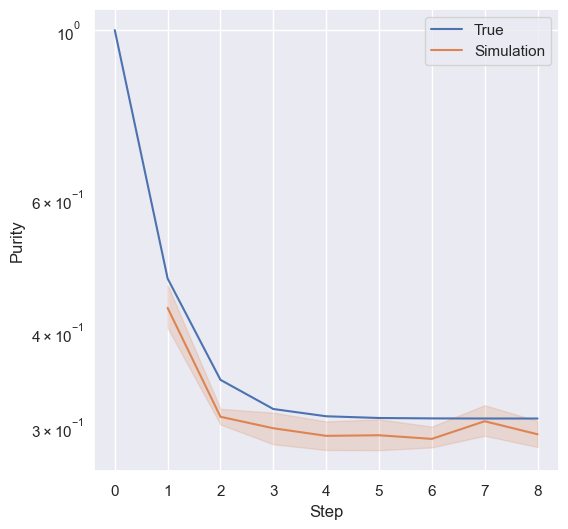

In [12]:
# plot simulated vs true purities
purities_df = pd.DataFrame(purities.T, columns=range(1, 9)).melt()
purities_df.columns=['Step', 'Purity']

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.lineplot(FP1evo(4, 4, np.arange(9)), errorbar=None, ax=ax)
sns.lineplot(data=purities_df, x='Step', y='Purity', legend='brief', ax=ax)
ax.set(yscale='log')
ax.legend(['True', 'Simulation'])